# LMC 3D structure

Luis,Angel,Xavi,Hector,Alfred,Roger...y viceversa :)

In [8]:
#######################

#### Load packages ####
#######################

from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
# import warnings
import sys
import numpy as np
import pandas as pd
import time



## Generate sintetic observations with errors

In [9]:
###################
#### Functions ####
###################

def proper2geo_fn(xyz,distCenterLMC,alphaCenterLMC,deltaCenterLMC,
                      posAngleLMC,inclAngleLMC):
 
# Transform samples of location coordinates in the proper frame of the LMC
# to the rectangular heliocentric frame
#
# References:
#  Van der Marel & Cioni (2001)
#  Weinberg and Nikolaev (2001)
# 
# Parameters: 
# -xyz                 A tensor of shape=(N, 3) containing N samples in the
#                     proper LMC frame 
# -N                   No of samples
# -distCenterLMC       Distance to the LMC centre (kpc)
# -alphaCenterLMC      RA of the LMC centre (rad)
# -deltaCenterLMC      Dec of the LMC centre (rad)
# -posAngleLMC         Position angle of the LON measured w.r.t. the North (rad)
# -inclAngleLMC        Inclination angle (rad)
#
# Return:             A tensor of shape=(N, 3) containing N samples of rectangular 
#                    coordinates in the heliocentric frame                 
 


    # Affine transformation from local LMC frame to heliocentric frame 

    s11 = np.sin(alphaCenterLMC)
    s12 = -np.cos(alphaCenterLMC) * np.sin(deltaCenterLMC)
    s13 = -np.cos(alphaCenterLMC) * np.cos(deltaCenterLMC)
    s21 = -np.cos(alphaCenterLMC)
    s22 = -np.sin(alphaCenterLMC) * np.sin(deltaCenterLMC)
    s23 = -np.sin(alphaCenterLMC) * np.cos(deltaCenterLMC)
    s31 = np.zeros([])
    s32 = np.cos(deltaCenterLMC)
    s33 = -np.sin(deltaCenterLMC)
 
    matrix = np.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = np.concatenate((
        np.shape(np.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ2 = np.reshape(matrix, output_shape.astype(int))

    
    LMC_center = np.stack(
        [
            distCenterLMC *
            np.cos(deltaCenterLMC) *
            np.cos(alphaCenterLMC),   
            distCenterLMC *
            np.cos(deltaCenterLMC) *
            np.sin(alphaCenterLMC),
            distCenterLMC *
            np.sin(deltaCenterLMC)
        ], axis=0)

    #print("LMC_center",LMC_center)
     
    # Linear transformation from proper to local LMC frame 
 
    
    s11 = np.cos(posAngleLMC)  
    s12 = -np.sin(posAngleLMC) * np.cos(inclAngleLMC)  
    s13 = -np.sin(posAngleLMC) * np.sin(inclAngleLMC)
    s21 = np.sin(posAngleLMC)  
    s22 = np.cos(posAngleLMC) * np.cos(inclAngleLMC)  
    s23 = np.cos(posAngleLMC) * np.sin(inclAngleLMC)  
    s31 = np.zeros([])  
    s32 = -np.sin(inclAngleLMC)  
    s33 = np.cos(inclAngleLMC)  
     
 
    matrix2 = np.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = np.concatenate((
        np.shape(np.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ5 = np.reshape(matrix2, output_shape.astype(int))
 
    #mat1=xyz.dot(OXYZ5)
    mat1=OXYZ5.dot(xyz.T).T
    #print("mat1",mat1.shape)
    #print(OXYZ2.shape)
    #output0n=mat1.dot(OXYZ2) + np.array(LMC_center)
    output0n=OXYZ2.dot(mat1.T).T + np.array(LMC_center)
    #print("output0n",output0n)
    #mat1 = np.matmul(OXYZ5,xyz) + np.zeros(3)
    #mat2 = np.matmul(OXYZ2,mat1) + LMC_center
    
    return output0n

 

def disk_fn(n, scaleHeight, scaleLength, psiAngle, ellFactor):
 
# Generate samples of location coordinates of the LMC disk in a proper  
# reference frame and transform them to a proper LMC reference frame 
# References:
#  Mancini et al. (2004)
#
# Parameters: 
# -N                   No of samples
# -scaleHeight         Disk scale height (kpc)
# -scaleLength         Disk scale length (kpc)
# -ellFactor           Disk ellipticity factor. For a circular disk set = 1                                                  
# -psiAngle            Disk minor axis position angle measured w.r.t. LON (rad)
#                     For a circular disk set = 0
#
# Return:             A tensor of shape=(n, 3) containing N samples of the   
#                    star locations in a local LMC reference frame                
 

    s11 =  np.cos(psiAngle) 
    s12 = -np.sin(psiAngle)   
    s13 = np.zeros([])
    s21 =  np.sin(psiAngle)
    s22 =  np.cos(psiAngle)  
    s23 = np.zeros([])
    s31 = np.zeros([])  
    s32 = np.zeros([])  
    s33 = np.ones([])
 
    matrix = np.stack((s11,s12,s13,s21,s22,s23,s31,s32,s33),
                      axis=-1)  # pyformat: disable
    output_shape = np.concatenate((
        np.shape(np.zeros(4))[:-1], (3, 3)), axis=-1)

    OXYZ6 = np.reshape(matrix, output_shape.astype(int))

    #S3_ = tf.linalg.LinearOperatorFullMatrix(OXYZ6)
    #S3_ALO = tfb.AffineLinearOperator(shift=tf.zeros(3), scale=S3_)
    
    #r = tfd.Gamma(concentration=2, rate=1./scaleLength).sample(n )
    r = np.random.gamma(shape = 2,scale = scaleLength, size = n)
    theta = np.random.uniform(low=0., high=2.*np.pi, size = n)

    x = ellFactor * r * np.cos(theta)
    y = r * np.sin(theta)

    z = np.random.laplace(loc=0., scale=scaleHeight, size=n )

    #chain = tfb.Chain([  S3_ALO ])
    
    #output1n=np.stack([x,y,z],axis=1).dot(OXYZ6)
    output1n=OXYZ6.dot(np.stack([x,y,z],axis=1).T).T # NO entenc perquè pero sembla que així queda ben encarat
    #print("mat11",output1n.shape)
    #mat1 = np.matmul(OXYZ6,np.stack([x,y,z],axis=1)) + np.zeros(3)

    return output1n

def geo2plx_fn( x  ):
# Transform rectangular heliocentric coordinates to (ra,dec,parallax) coordinates

        x0 = x[..., 0]
        x1 = x[..., 1]
        x2 = x[..., 2]
        y0 = np.array([])
        #for element in range(len(x1)):
        #    if x1[element] > 0.:
        #        y0 = np.append(y0,np.dot(180./np.pi,np.arctan2(x1[element],x0[element])))
        #    else:
        #        y0 = np.append(y0,np.dot(180./np.pi,np.arctan2(x1[element],x0[element]))+360.)
                
                
        #y0 = np.where(x1>0,np.dot(180.0/np.pi,np.arctan2(x1,x0)),np.dot(180.0/np.pi,np.arctan2(x1,x0))+360.)
        y0 = np.where(x1>0,180.0/np.pi*np.arctan2(x1,x0),180.0/np.pi*np.arctan2(x1,x0)+360.)
        
        #print(y0)     
        y2 = 1./np.sqrt(np.sum(np.multiply(x, x), axis=1))
        #print(y2)
        # y2 = tf.linalg.norm(x, axis=1)
        y1 = np.dot(180.0/np.pi, np.arcsin(x2/(1./y2)))
        #print(y1)
        output2n=np.stack([y0, y1, y2], axis=1)
        return output2n

 

def measurements_fn(x , raErrorMean, raErrorVar , decErrorMean, 
                    decErrorVar, plxErrorMean, plxErrorVar ): 
    
    n =  x.shape[0]

    raErrorShape  = (raErrorMean ** 2)/raErrorVar
    raErrorScale  = raErrorVar/raErrorMean 

    decErrorShape  = (decErrorMean ** 2)/decErrorVar
    decErrorScale  = decErrorVar/decErrorMean 

    plxErrorShape  = (plxErrorMean ** 2)/plxErrorVar
    plxErrorScale  = plxErrorVar/plxErrorMean 

    ra_error = np.random.gamma(shape=raErrorShape, 
                         scale=raErrorScale,size=n )
    
    dec_error = np.random.gamma(shape=decErrorShape, 
                          scale=decErrorScale,size=n )
    
    plx_error = np.random.gamma(shape=plxErrorShape, 
                          scale=plxErrorScale,size=n )

    x0 = np.array(x[:, 0])
    x1 = np.array(x[:, 1])
    x2 = np.array(x[:, 2])

    #uncs = np.stack([ra_error, dec_error, plx_error], axis=1)
    #print("x0=",np.array(x0).shape)
    
    rax=np.random.normal(x0,scale=ra_error)
    decx=np.random.normal(x1,scale=dec_error)
    parallaxx=np.random.normal(x2,scale=plx_error)

    obs =  np.stack([rax,decx,parallaxx],axis=1)

    return obs 

     

 



In [10]:
####################################
### Generate synthetic catalogue ###
####################################

# LMC fixed hyperparameters
dist_centre_lmc=65. 
alpha_centre_lmc=80.8939*np.pi/180. 
delta_centre_lmc=-69.7561*np.pi/180.
pos_angle_lmc=(122.5 + 90.)*np.pi/180.
inc_angle_lmc=21*np.pi/180. 

# Disk component fixed hyperparameters
disk_scale_height = 0.35
disk_scale_length = 1.6
pos_angle_disk = 202.7*np.pi/180
ell_factor_disk = 0.688 

# Uncertainty on measurements roughly estimated from the catalogue
ra_error_mean   = 0.1711426
ra_error_var = 0.006506719

dec_error_mean    =  0.1804739
dec_error_var = 0.007289793 

plx_error_mean  =  0.1758596
plx_error_var = 0.006775405 


# Set No of samples we want to generate
N = 10000000

# Generate disk location coordinates in the LMC proper reference frame
xyz_propern = disk_fn(N, disk_scale_height, disk_scale_length, 
                     pos_angle_disk - pos_angle_lmc, ell_factor_disk)

# Transform from proper to heliocentric frame
xyz_geon =  proper2geo_fn(xyz_propern, dist_centre_lmc, alpha_centre_lmc,
                         delta_centre_lmc, pos_angle_lmc, inc_angle_lmc )

# Generate (ra,dec,plx) true values

cyl_plxn  =   geo2plx_fn(xyz_geon)

# Generate (ra,dec,plx) measurements & uncertainties

obs=measurements_fn(cyl_plxn , ra_error_mean, ra_error_var , 

                dec_error_mean, dec_error_var,  plx_error_mean, plx_error_var )  

In [11]:
a=pd.DataFrame(data=obs, columns=["ra", "dec","plx"])
tall=a['plx']>0
#lmcpositive=lmc[tall]
a=a[tall]

tall2=a["plx"]<0.03
simu1=np.array(a[tall2])

In [12]:
ra=simu1[:,0]
dec=simu1[:,1]
parallax=simu1[:,2]
bins_ra_3 = np.arange(50,120,70/15)
bins_dec_3 = np.arange(-80,-50,30/15)
ret=stats.binned_statistic_2d(ra, dec, parallax, statistic='mean', bins=[bins_ra_3,bins_dec_3], range=None, expand_binnumbers=False)
retstd=stats.binned_statistic_2d(ra, dec, parallax, statistic='std', bins=[bins_ra_3,bins_dec_3], range=None, expand_binnumbers=False)
mean1=ret.statistic
std1=retstd.statistic
xedges=ret.x_edge

yedges=ret.y_edge



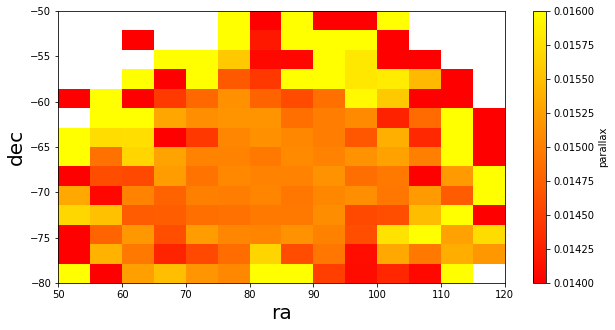

In [13]:
plt.figure(figsize=(10,5))
im=plt.imshow(mean1.T, aspect='auto',interpolation="nearest", origin="upper",cmap='autumn',extent=[50,120,-50,-80],vmin=0.014,vmax=0.016)
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("ra",fontsize=20)
plt.ylabel("dec",fontsize=20)
plt.xlim(50,120)
cbar=plt.colorbar()
cbar.set_label('parallax')
plt.show()

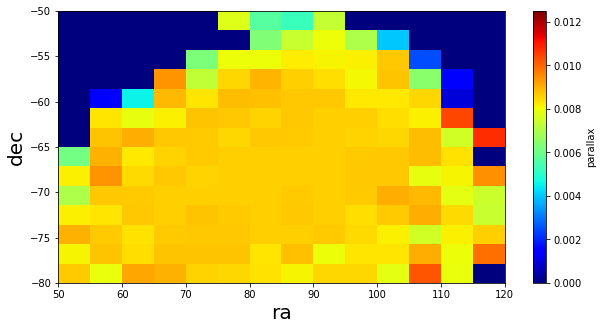

In [14]:
plt.figure(figsize=(10,5))
im=plt.imshow(std1.T, aspect='auto',interpolation="nearest", origin="upper",cmap='jet',extent=[50,120,-50,-80],vmin=0,vmax=0.0125)
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("ra",fontsize=20)
plt.ylabel("dec",fontsize=20)
plt.xlim(50,120)
cbar=plt.colorbar()
cbar.set_label('parallax')
plt.show()

# Inferencia usando ABC


## Toy Example


We need to provide:

- a dataset
- a forwards simulating model for the data
- a method defining the distance metric


### astroABC for python

### Key features

-    Parallel sampling using MPI or multiprocessing
-    MPI communicator can be split so both the sampler, and simulation launched by each particle, can run in parallel

-    A Sequential Monte Carlo sampler (see e.g. Toni et al. 2009, Beaumont et al. 2009, Sisson & Fan 2010)

-    A method for iterative adapting tolerance levels using the qth quantile of the distance for t iterations (Turner & Van Zandt (2012))

-    Scikit-learn covariance matrix estimation using Ledoit-Wolf shrinkage for singular matrices

-    A module for specifying particle covariance using method proposed by Turner & Van Zandt (2012), optimal covariance matrix for a multivariate normal perturbation kernel, local covariance estimate using scikit-learn KDTree method for nearest neighbours (Filippi et al 2013) and a weighted covariance (Beaumont et al 2009)

-    Restart files output frequently so an interrupted run can be resumed at any iteration
-    Output and restart files are backed up every iteration
-    User defined distance metric and simulation methods
-    A class for specifying heterogeneous parameter priors
-    Methods for drawing from any non-standard prior PDF e.g using Planck/WMAP chains
-    A module for specifying a constant, linear, log or exponential tolerance level
-    Well-documented examples and sample scripts


In [15]:
import astroabc

# We define the function to perform the simulations

In [17]:
# Función de la simulación adaptada para funcionar para ABC, de momento sin errores

def simu_LMC(param,pool=None):
    # LMC fixed hyperparameters
    #print(param)
    dist_centre_lmc=param[0]
    #print(dist_centre_lmc)
    alpha_centre_lmc=param[5]*np.pi/180. #80.8939*np.pi/180. 
    delta_centre_lmc=param[6]*np.pi/180.#-69.7561*np.pi/180.
    pos_angle_lmc=(param[3] + 90.)*np.pi/180.
    inc_angle_lmc=param[1]*np.pi/180. #34.7*np.pi/180. 

    # Disk component fixed hyperparameters
    disk_scale_height = 0.35
    disk_scale_length = 1.6
    pos_angle_disk =param[4]*np.pi/180 #202.7*np.pi/180
    ell_factor_disk =param[2]# 0.688 
    # Set No of samples we want to generate
    N = 5000000   
    if dist_centre_lmc>0 and ell_factor_disk>0 and inc_angle_lmc>0 and disk_scale_height>0 and  disk_scale_length>0 and 0< param[3]<180 and 180<param[4]<360 and 0.<param[5]<180. and -90.<param[6]<0.:
    # Generate disk location coordinates in the LMC proper reference frame
        xyz_proper = disk_fn(N, disk_scale_height, disk_scale_length, 
                         pos_angle_disk - pos_angle_lmc, ell_factor_disk)

    # Transform from proper to heliocentric frame
        xyz_geo =  proper2geo_fn(xyz_proper, dist_centre_lmc, alpha_centre_lmc,
                             delta_centre_lmc, pos_angle_lmc, inc_angle_lmc )

        # Generate (ra,dec,plx) true values

        cyl_plx  =   geo2plx_fn(xyz_geo)

        result=np.array(cyl_plx)
        #print(result)
        ra=result[:,0]
        #print(ra)
        #plt.figure()
        #plt.hist(ra,bins=50)
        #plt.show()
        dec=result[:,1]
        #print(dec)
        parallax=result[:,2]
        #print(parallax)
        bins1 = np.arange(50,120,70/15)
        bins2 = np.arange(-80,-50,30/15)
        ret=stats.binned_statistic_2d(ra, dec, parallax, statistic='mean', bins=[bins1,bins2], range=None, expand_binnumbers=False)
        #print(ret.statistic)
        meanresult=ret.statistic
        #print(meanresult.shape)
        sym=np.reshape(meanresult,196)
        #print(sym)
    else:
        sym=np.array([0])
    return sym
    
    
    
    

# We define the distance metric that we want to use

In [18]:
# Métrica de distáncia sencilla. Se puede cambiar cuando queramos.

def metric_asymetries(observed,simulated): # Function to compute the distance metric using Chi^2
    
   
    if simulated.size==1:
        mychisum=np.inf
        #print("here")
    else:
        #print(simulated)
        nanos=np.count_nonzero(np.isnan(simulated)) # Count the number of bins with nans
        lens=len(simulated)                      


        if nanos>0.75*lens:  # if more than 75% of the bins have nans assign distance=infinity
            mychisum=float('Inf')
            #print("here2")
        else:
            mychi=np.nansum(((observed-simulated)/sigma)**2) # Sum of all Chi^2 for each bin                  
            Nbin=abs(lens-nanos)                                 # Compute the number of bins without nans
            mychisum=np.sum(mychi)/Nbin                     # Normalization over the number of bins
            #print(mychisum)                       
    return mychisum

In [19]:
ra_std=simu1[:,0]
dec_std=simu1[:,1]
parallax_std=simu1[:,2]
bins_ra_std = np.arange(50,120,70/15)
bins_dec_std = np.arange(-80,-50,30/15)
hstd=stats.binned_statistic_2d(ra_std, dec_std, parallax_std, statistic='std', bins=[bins_ra_std,bins_dec_std], range=None, expand_binnumbers=False)
sigma=np.reshape(hstd.statistic,196)+0.0001

Next we need to set some keywords for astroABC. This can be done by creating a dictionary of inputs which are passed to the sampler. Many of these entries have defaults and do not need to be specified explicitly.
Only the name of the distance metric method needs to be explicity provided as a keyword.
The full set of keywords are given in the doc string of the class. Some examples are

- tol_type: which specifies the decreasing tolerance levels. "exp","lin", "log" and "const" are options. (default = 'exp')

- verbose: level of verbosity, 0 = no printout to screen, 1 = print to screen  (default = 0)

- adapt_t: Boolean True/False for adaptive threshold setting (default = False)

- threshold: qth quantile used in adaptive threshold setting (default = 75)

- pert_kernel: 1 =component wise pert. with local diag variance; 2 = multivariate pert. based on local covariance

- variance_method: 0 =weighted covariance, 1= Filippi, 2 = TVZ, 3= Leodoit_Wolf, 4=k-nn (default = 0)

- dfunc:method for calculating the distance metric

- from_restart: Boolean True/False

- restart: string name of restart file

- outfile:string specifying name of output file (default = abc_out.txt)

- mpi: Boolean True/False (default = False)

- mp:Boolean True/False (default = False)

- num_proc:number of threads for mp setting (default = None)

Please see the doc strings of the astroABC sampler for details on each of these settings.

In [20]:
if __name__ == "__main__":
    prop={'tol_type':"exp","verbose":1,'adapt_t':True,'threshold':75,
        'pert_kernel':2,'variance_method':0, 'dfunc':metric_asymetries, 'restart':"restart_abc3.txt", 'outfile':"abc_mpi_obsSintetic15_3bo.txt",'mpi':False,'mp':True,'num_proc':8,
        'from_restart':False}

Next we specify priors for each of the parameters we want to vary in the sampler. This is done by specifying a list of tuples. The zeroth element in each tuple should be a string specifying the prior for this parameter and the first element should be a list of the hyperparameters needed for this prior.

In [21]:
priors =  [('uniform', [5., 200.]),('uniform', [0., 45.]),('uniform', [0.4, 0.8]),('uniform', [100., 200.]),('uniform', [180., 260.]),('uniform', [70., 90.]),('uniform', [-80., -60.])] # Define the priors por the parameters to explore

In [22]:

param=[65.,21,0.688,122.5  , 202.7 ,80.8939,-69.7561]
simu2=simu_LMC(param)
mean2=simu2.reshape(14,14)

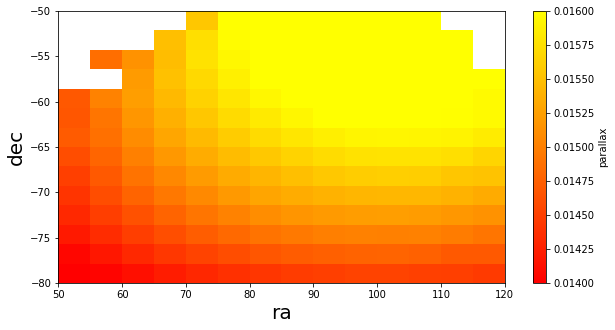

In [23]:
plt.figure(figsize=(10,5))
im=plt.imshow(mean2.T, aspect='auto',interpolation="nearest", origin="upper",cmap='autumn',extent=[50,120,-50,-80],vmin=0.014,vmax=0.016)
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("ra",fontsize=20)
plt.ylabel("dec",fontsize=20)
plt.xlim(50,120)
cbar=plt.colorbar()

cbar.set_label('parallax')
plt.show()

## We fo for the main function

In [24]:
def main():
    #param=[50,34.7,0.688,122.5,202.7]
    ra=simu1[:,0]
    dec=simu1[:,1]
    parallax=simu1[:,2]
    bins_ra = np.arange(50,120,70/15)
    bins_dec = np.arange(-80,-50,30/15)
    h=stats.binned_statistic_2d(ra, dec, parallax, statistic='mean', bins=[bins_ra,bins_dec], range=None, expand_binnumbers=False)
    data1=h.statistic

    print(data1.shape)
    data=np.reshape(data1,196)
    
    sampler = astroabc.ABC_class(7,100,data,[100,0.0001],100,priors,**prop)
    model_sim=simu_LMC
    
    
    sampler.sample(model_sim)

Finally we run the main program

In [ ]:
main()

(14, 14)
	 	
	 ########################     astroABC     ########################	
	 	
	 Npart=100 	 numt=100 	 tol=[100.0000,0.0001] exp
	 Priors= [('uniform', [5.0, 200.0]), ('uniform', [0.0, 45.0]), ('uniform', [0.4, 0.8]), ('uniform', [100.0, 200.0]), ('uniform', [180.0, 260.0]), ('uniform', [70.0, 90.0]), ('uniform', [-80.0, -60.0])]
	 Step: 0 	 tol: 100.0 	 Params: [123.63015275788372, 22.312106154419656, 0.6015121411505038, 137.60175297622953, 223.08187675398244, 81.06463765909399, -72.50740268635454]
	 Step: 1 	 tol: 4.889146752388565 	 Params: [126.7052406614387, 26.184499851249157, 0.6626443137449063, 125.18814782305823, 226.97214666192514, 81.53039895934332, -74.54133334816949]
	 Step: 2 	 tol: 1.0628745937597042 	 Params: [122.32673629454534, 25.986381152460222, 0.6297342877895651, 121.73413610178056, 226.39380426074243, 78.2226873663914, -75.20321472052446]
	 Step: 3 	 tol: 0.8521947233302762 	 Params: [112.81093404150532, 29.017155879685596, 0.628009414979231, 128.8044270

## A bit of theory

### Introduction to ABC

Approximate Bayesian computation
(ABC) and so called "likelihood free" Markov chain Monte Carlo techniques are popular methods
for tackling parameter inference in scenarios where the likelihood is intractable or unknown.
These methods are called likelihood free as they are free from any assumption about the form of the likelihood, as ABC aims to simulate samples from the parameter posterior distribution directly.
In traditional MCMC approaches the target distribution is the posterior distribution of interest and in practice our estimate of this pdf is approximate due to finite sampling time resulting in a correlated chain which we hope has converged.
ABC methods are also approximate in the sense that samples are generated from trial distributions which we hope are close to the real posterior of interest.
The [wikipedia]( https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) page on ABC has a good introduction to the topic.

The simplest ABC algorithm is rejection sampling. 
Given a set of parameters, $\theta$, with associated priors, $\pi(\theta)$ and a forward simulated model for the data,

$\pi(D|\theta)$. 

We can simulate from the posterior distribution, $P(\theta|D)$, by first drawing sample parameters

$\theta^* \sim \pi(\theta)$, 

then simulating a dataset with these parameters 

$D^* \sim \pi(D|\theta^*)$.

In a simple rejection sampling algorithm, we reject $D^*$  unless it matches the true data, $D$.
For discrete data this algorithm would not be practical as many simulated samples would be rejected until an exact match is found.
In practice we make an approximation and accept simulated datasets which are "close" to the true data. This introduces the idea of a distance metric and tolerance level in ABC. We accept proposed parameters $\theta^*$, if 

$\rho(D^* - D) <\epsilon$

where $\rho$ is the distance metric, which could be e.g. the Euclidean norm $||D^* - D||$,  and $\epsilon$ is a tolerance threshold. This procedure produces samples from 

$P(\theta | \rho(D^*-D)<\epsilon)$ 

which will be a good approximation of the true posterior if $\epsilon$ is small.

The tolerance threshold in ABC controls which of the proposed parameters are accepted given the distance metric. There are two considerations in choosing this threshold. If the tolerance is too high then too many proposed parameters are accepted and the prior distribution dominates the results e.g. if the tolerance level is infinity then we would just recover the prior distribution from the algorithm. If the tolerance level is too low then the sampler is very inefficient with many proposed points being rejected.
A compromise is to select a set of decreasing tolerance levels where for the initial iterations in the algorithm we accept points in parameter space which do not represent the data with high accuracy but as the algorithm progresses the tolerance level decreases and our estimate of the true posterior distribution improves.

In many cases it may be simpler to work with some lower dimension summary statistic of the data, $S(D)$,
rather then the full dataset. In this case the chosen statistic needs to be a so-called *sufficient statistic* in that
any information about the parameter of interest which is contained in the data, is also contained in the summary statistic. More formally a statistic $S(D)$ is sufficient for $\theta$ if the distribution $P(D|S(D))$ does not depend on $\theta$.
This requirement ensures that in summarizing the data we have not thrown away constraining information about $\theta$.


### ABC Sequential Monte Carlo

Rather than drawing candiates $\theta^*$, one at a time, we can
speed up the ABC algorithm by working with large
pools of candidates, called particles, simultaneously. 
At each stage of the algorithm the particles are perturbed and filtered using the distance metric, and eventually
this pool of particles move closer and closer to simulating from the desired posterior distribution.
This approach is known as Sequential Monte Carlo or Particle Monte Carlo sampling.

Outline of the ABC SMC algorithm:

- At iteration 0, for each particle:
    1. Generate $\theta_i^* \sim \pi(\theta)$. 
    2. Simulate a dataset $D_i^* \sim \pi(D|\theta_i^*)$
    3. If  $\rho(S(D_i^*) - S(D))<\epsilon_0$ accept $\theta_i^*$ else go to 1.
- set $\theta_{i,0} = \theta_i^*$
- set weights for each particle $w_{i,0} = 1/N$
- evaluate the covariance amongst particles $\sigma^2_{1:N;0}$
- At iteration t>0, for each particle: 
    4. Sample random particle from previous iteration $\theta_i^* \sim \theta_{1:N;0}$ 
    5. Perturb $\theta_i^*$ by drawing $\theta_i^{**} \sim \mathcal{N}(\theta^*, \sigma^2_{t-1})$
    6. Simulate a dataset $D_i^* \sim \pi(D|\theta_i^{**})$
    7. If  $\rho(S(D_i^*) - S(D))<\epsilon_0$ accept $\theta_i^{**}$ else go to 4.
- set $\theta_{i,t} = \theta_i^{**}$
- set weights for each particle $w_{i,t}$ using a transition kernel
- evaluate the covariance amongst particles $\sigma^2_{1:N;t}$
    
Different ABC SMC algorithms can be distinguished
by how sampling weights are assigned to the particles in the pool.
In order to perturb and filter the particles we need a transition kernel. The transition
kernel serves the same purpose as the proposal distribution in a standard
MCMC algorithm. The transition kernel specifies the distribution of a random variable that will
be added to each particle to move it around in the parameter space.
For more details on this please see 
[Beaumont et al 2009]( https://arxiv.org/abs/0805.2256).